In [1]:
!pip install torchsummary -q

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torchsummary import summary
from PIL import Image
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os

In [3]:
classes = {'1NonCOVID': 0, '2COVID': 1, '3CAP': 2}
declasses = {0: '1NonCOVID', 1: '2COVID', 2: '3CAP'}

In [4]:
class GetDataset(Dataset):
    def __init__(self, path, folder, channel, transform=None):
        self.path = path
        self.folder = folder
        self.channel = channel
        self.transform = transform

    def __len__(self):
        return len(os.listdir(os.path.join(self.path, self.folder)))

    def __getitem__(self, index):
        img_name = sorted(os.listdir(os.path.join(self.path, self.folder)))[index]
        
        if self.channel == 3:
            ch = 'RGB'
        else:
            ch = 'L'
            
        image = Image.open(os.path.join(self.path, self.folder, img_name)).convert(ch)
        label = classes[self.folder]
        
        if self.transform:
            image = self.transform(image)
            

        return image, label

In [5]:
PATH = '../input/large-covid19-ct-slice-dataset/curated_data/curated_data/'
Folders = ['1NonCOVID', '2COVID', '3CAP']
# stats = (0.5,), (0.5,)
stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
size = 224
batch_size=128
channels = 3

transformer = T.Compose([
    T.Resize(size), 
    T.CenterCrop(size),
    T.ToTensor(),
    T.Normalize(*stats)
])

In [6]:
noncovid = GetDataset(PATH, Folders[0], channels, transformer)
covid = GetDataset(PATH, Folders[1], channels, transformer)
cap = GetDataset(PATH, Folders[2], channels, transformer)

In [7]:
print(len(noncovid), noncovid[0][0].size())
print(len(covid), covid[0][0].size())
print(len(cap), cap[0][0].size())

6893 torch.Size([3, 224, 224])
7593 torch.Size([3, 224, 224])
2618 torch.Size([3, 224, 224])


In [8]:
def denorm(image, stats=stats):
    return image * stats[1] + stats[0]

In [9]:
torch.manual_seed(42)

non_val = int(len(noncovid) * 0.1)
co_val = int(len(covid) * 0.1)
cp_val = int(len(cap) * 0.1)

noncovid, val_noncovid = random_split(noncovid, [len(noncovid) - non_val, non_val])
covid, val_covid = random_split(covid, [len(covid) - co_val, co_val])
cap, val_cap = random_split(cap, [len(cap) - cp_val, cp_val])

In [10]:
dataset = ConcatDataset([noncovid, covid, cap])
val_dataset = ConcatDataset([val_noncovid, val_covid, val_cap])

print(len(dataset), len(val_dataset))

15395 1709


In [11]:
dl = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denorm(images, stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

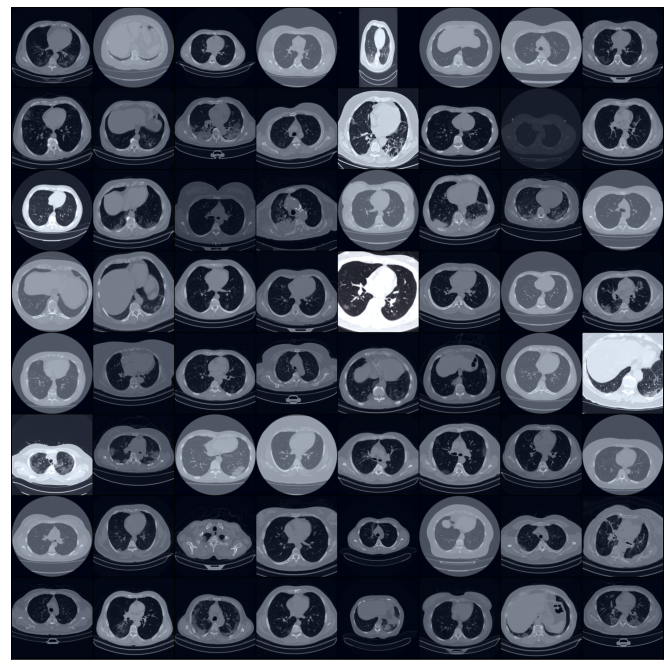

In [13]:
show_batch(dl)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Costum Model

In [15]:
class COVID_CT(nn.Module):
    def __init__(self, in_channels=3, hidden_size=64, num_classes=2):
        super().__init__()
        # in: (3, 256, 256)
        self.network = nn.Sequential(
            self._conv_block(in_channels, hidden_size),
            self._conv_block(hidden_size, hidden_size, pool=True, pool_size=2), # (hidden, 128, 128)
            self._conv_block(hidden_size, hidden_size * 2),
            self._conv_block(hidden_size * 2, hidden_size * 2, pool=True, pool_size=2), # (hidden*2, 64, 64)
            self._conv_block(hidden_size * 2, hidden_size * 4),
            self._conv_block(hidden_size * 4, hidden_size * 4, pool=True, pool_size=2), # (hidden*4, 32, 32)
            self._conv_block(hidden_size * 4, hidden_size * 8),
            self._conv_block(hidden_size * 8, hidden_size * 8, pool=True, pool_size=4), # (hidden*8, 8, 8)
            self._conv_block(hidden_size * 8, hidden_size * 16),
            self._conv_block(hidden_size * 16, hidden_size * 16, pool=True, pool_size=4), # (hidden*16, 2, 2)
        )
        
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(hidden_size * 16 * 2 * 2, 256), 
                                        nn.Dropout(0.5), 
                                        nn.Linear(256, num_classes))
    
    
    def forward(self, x):
        x = self.network(x)
        y = self.classifier(x)
        return y
    
    
    def _conv_block(self, in_channels, out_channels, 
                    kernel_size=3, stride=1, padding=1, 
                    pool: bool = False, pool_size: int = None):
        
        block = [nn.Conv2d(in_channels, out_channels, 
                           kernel_size=kernel_size, stride=stride, 
                           padding=padding), 
                 nn.ReLU(inplace=True)]
        if pool:
            if pool_size is None:
                raise TypeError("'pool_size' must be an integer")
            block.append(nn.MaxPool2d(pool_size))
        
        return nn.Sequential(*block)
    
    def summery(self, input_size):
        return summary(self, input_size)

### Pretrained resnet34

In [16]:
class COVID_CT(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)
    
    def summery(self, input_size):
        return summary(self, input_size)

In [17]:
model = COVID_CT(num_classes=3).to(device)
model.summery((3, 256, 256))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [18]:
learning_rate = 1e-4
n_epochs = 10

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
def train(epoch, n_epochs, model, dl, loss_func, device, optimizer, ds=dataset):
    model.train(True)
    torch.set_grad_enabled(True)
    
    epoch_loss = 0.0
    epochs_acc = 0
    
    tq_batch = tqdm(dl, total=len(dl))
    for images, labels in tq_batch:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outs = model(images)
        _, preds = torch.max(outs, 1)
        
        loss = loss_func(outs, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epochs_acc += torch.sum(preds == labels).item()
        
        tq_batch.set_description(f'Epoch [{epoch + 1}/{n_epochs}]')
        tq_batch.set_postfix_str('loss = {:.4f}'.format(loss.item()))

            
    epoch_loss = epoch_loss / len(dl)
    epochs_acc = epochs_acc / len(ds)

    return epoch_loss, epochs_acc

In [21]:
def evaluate(model, dl, loss_func, device, ds=val_dataset):

    model.train(False)

    epoch_loss = 0
    epochs_acc = 0
    tq_batch = tqdm(dl, total=len(dl), leave=False)
    for images, labels in tq_batch:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = loss_func(outputs, labels)

        epoch_loss += loss.item()
        epochs_acc += torch.sum(preds == labels).item()
        tq_batch.set_description(f'Evaluate Model')
        
    epoch_loss = epoch_loss / len(dl)
    epochs_acc = epochs_acc / len(ds)

    return epoch_loss, epochs_acc

In [22]:
def fit(n_epochs, model, train_dataloader, valid_dataloader, loss_func, device, optimizer):
    
    history = []
    val_loss_ref = float('inf')
    patient = 5
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        
        loss, acc = train(epoch, n_epochs, model, train_dataloader, loss_func, device, optimizer)
        val_loss, val_acc = evaluate(model, valid_dataloader, loss_func, device)
        
        history.append({'loss': loss, 'acc': acc, 'val_loss': val_loss, 'val_acc': val_acc})

        statement = "[loss]={:.4f} - [acc]={:.4f} - \
[val_loss]={:.4f} - [val_acc]={:.4f}".format(loss, acc, val_loss, val_acc,)
        print(statement)
        ####### Checkpoint
        if val_loss < val_loss_ref:
            patient = 5
            val_loss_ref = val_loss
            model_path = './face_mask_detection_checkpoint.pth'
            torch.save(model.state_dict(), model_path)
            print(f"[INFO] Saving model dict, Epoch={epoch + 1}")
        else:
            if patient == 0: 
                break
            patient -= 1
            print(f"[INFO] {patient} lives left!")

    return history

In [23]:
res = fit(n_epochs, model, dl, val_dl, criterion, device, optimizer)

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[loss]=0.1957 - [acc]=0.9245 - [val_loss]=0.0602 - [val_acc]=0.9813
[INFO] Saving model dict, Epoch=1


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[loss]=0.0419 - [acc]=0.9860 - [val_loss]=0.0392 - [val_acc]=0.9912
[INFO] Saving model dict, Epoch=2


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[loss]=0.0177 - [acc]=0.9944 - [val_loss]=0.0297 - [val_acc]=0.9895
[INFO] Saving model dict, Epoch=3


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[loss]=0.0117 - [acc]=0.9966 - [val_loss]=0.0745 - [val_acc]=0.9737
[INFO] 4 lives left!


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[loss]=0.0152 - [acc]=0.9955 - [val_loss]=0.0430 - [val_acc]=0.9877
[INFO] 3 lives left!


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[loss]=0.0161 - [acc]=0.9945 - [val_loss]=0.0411 - [val_acc]=0.9877
[INFO] 2 lives left!


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[loss]=0.0143 - [acc]=0.9953 - [val_loss]=0.0311 - [val_acc]=0.9918
[INFO] 1 lives left!


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[loss]=0.0091 - [acc]=0.9968 - [val_loss]=0.0359 - [val_acc]=0.9906
[INFO] 0 lives left!


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[loss]=0.0053 - [acc]=0.9983 - [val_loss]=0.0176 - [val_acc]=0.9953
[INFO] Saving model dict, Epoch=9


  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

[loss]=0.0012 - [acc]=0.9997 - [val_loss]=0.0127 - [val_acc]=0.9959
[INFO] Saving model dict, Epoch=10


In [24]:
def show_results(history):
    accuracy = [res['acc'] for res in history]
    losses = [res['loss'] for res in history]
    val_accuracy = [res['val_acc'] for res in history]
    val_losses = [res['val_loss'] for res in history]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    ax1.plot(losses, '-o', label = 'Loss')
    ax1.plot(val_losses, '-o', label = 'Validation Loss')
    ax1.legend()

    ax2.plot(100 * np.array(accuracy), '-o', label = 'Accuracy')
    ax2.plot(100 * np.array(val_accuracy), '-o', label = 'Validation Accuracy')
    ax2.legend();
    
    fig.show()

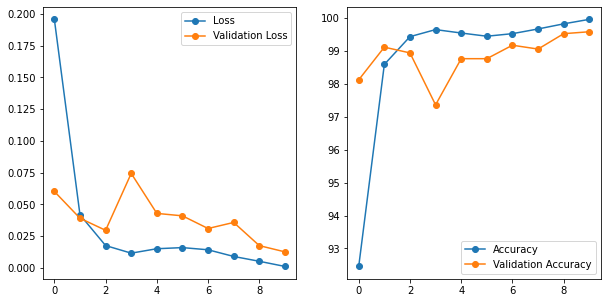

In [25]:
show_results(res)

In [26]:
y_test, y_pred = [], []
for imgs, lbls in tqdm(val_dl):
    imgs = imgs.to(device)
    outs = model(imgs)
    _, preds = torch.max(outs, dim = 1)
    y_test += lbls.tolist()
    y_pred += preds.tolist()


  0%|          | 0/14 [00:00<?, ?it/s]

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

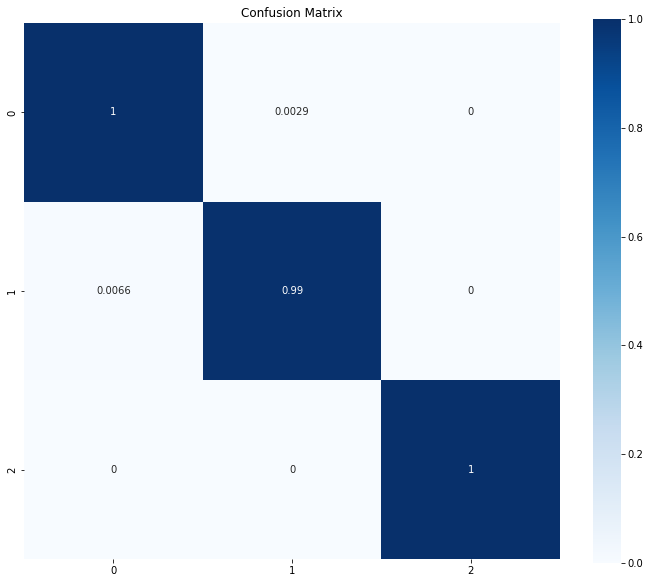

In [28]:
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(12, 10))
plt.title('Confusion Matrix')
sns.heatmap(cm_df, annot=True, cmap='Blues', square=True);

In [29]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       689
           1       1.00      0.99      1.00       759
           2       1.00      1.00      1.00       261

    accuracy                           1.00      1709
   macro avg       1.00      1.00      1.00      1709
weighted avg       1.00      1.00      1.00      1709

